<a href="https://colab.research.google.com/github/linhlinhle997/object-detection-techniques/blob/features%2Fod-part1/yolov1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  YOLOv1

In [ ]:
!pip install timm

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patches
from collections import Counter
import cv2
from glob import glob
from tqdm import tqdm
from termcolor import colored
import timm

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, SubsetRandomSampler
import torchvision
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import ConcatDataset

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.1 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## Convert Annotations to YOLO Format

In [3]:
def convert_to_yolo_format(target, img_width, img_height, class_mapping):
    """
    Convert annotation data from VOC format to YOLO format.

    Parameters:
    target (dict): Annotation data from VOCDetection dataset.
    img_width (int): Width of the original image.
    img_height (int): Height of the original image.
    class_mapping (dict): Mapping from class names to integer IDs.

    Returns:
    torch.Tensor: Tensor of shape [N, 5] for N bounding boxes,
                  each with [class_id, x_center, y_center, width, height].
    """
    # Extract the list of annotations from the target dictionary.
    annotations = target["annotation"]["object"]

    # Get the real width and height of the image from the annotation.
    real_width = int(target["annotation"]["size"]["width"])
    real_height = int(target["annotation"]["size"]["height"])

    # Ensure that annotations is a list, even if there's only one object.
    if not isinstance(annotations, list):
        annotations = [annotations]

    # Initialize an empty list to store the converted bounding boxes.
    boxes = []

    # Loop through each annotation and convert it to YOLO format.
    for anno in annotations:
        xmin = int(anno["bndbox"]["xmin"]) / real_width
        xmax = int(anno["bndbox"]["xmax"]) / real_width
        ymin = int(anno["bndbox"]["ymin"]) / real_height
        ymax = int(anno["bndbox"]["ymax"]) / real_height

        # Calculate the center coordinates, width, and height of the bounding box.
        x_center = (xmin + xmax) / 2
        y_center = (ymin + ymax) / 2
        width = xmax - xmin
        height = ymax - ymin

        # Retrieve the class name from the annotation and map it to an integer ID.
        class_name = anno["name"]
        class_id = class_mapping[class_name] if class_name in class_mapping else 0

        # Append the YOLO formatted bounding box to the list.
        boxes.append([class_id, x_center, y_center, width, height])

    # Convert the list of boxes to a torch tensor.
    return np.array(boxes)


## Custom Dataset for YOLOv1

In [4]:
class CustomVOCDataset(torchvision.datasets.VOCDetection):
    def init_config_yolo(self, class_mapping, S=7, B=2, C=20, custom_transforms=None):
        # Initialize YOLO-specific configuration parameters.
        self.S = S  # Grid size S x S
        self.B = B  # Number of bounding boxes
        self.C = C  # Number of classes
        self.class_mapping = class_mapping  # Mapping of class names to class indices
        self.custom_transforms = custom_transforms

    def __getitem__(self, index):
        # Get an image and its target (annotations) from the VOC dataset.
        image, target = super(CustomVOCDataset, self).__getitem__(index)
        img_width, img_height = image.size

        # Convert target annotations to YOLO format bounding boxes.
        boxes = convert_to_yolo_format(
            target, img_width, img_height, self.class_mapping
        )

        just_boxes = boxes[:, 1:]
        labels = boxes[:, 0]

        # Tranforme
        if self.custom_transforms:
            sample = {"image": np.array(image), "bboxes": just_boxes, "labels": labels}

            sample = self.custom_transforms(**sample)
            image = sample["image"]
            boxes = sample["bboxes"]
            labels = sample["labels"]

        # Create an empty label matrix for YOLO ground truth.
        label_matrix = torch.zeros((self.S, self.S, self.C + 5 * self.B))

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.float32)
        image = torch.as_tensor(image, dtype=torch.float32)

        # Iterate through each bounding box in YOLO format.
        for box, class_label in zip(boxes, labels):
            x, y, width, height = box.tolist()
            class_label = int(class_label)

            # Calculate the grid cell (i, j) that this box belongs to.
            i, j = int(self.S * y), int(self.S * x)
            x_cell, y_cell = self.S * x - j, self.S * y - i

            # Calculate the width and height of the box relative to the grid cell.
            width_cell, height_cell = (
                width * self.S,
                height * self.S,
            )

            # If no object has been found in this specific cell (i, j) before:
            if label_matrix[i, j, 20] == 0:
                # Mark that an object exists in this cell.
                label_matrix[i, j, 20] = 1

                # Store the box coordinates as an offset from the cell boundaries.
                box_coordinates = torch.tensor(
                    [x_cell, y_cell, width_cell, height_cell]
                )

                # Set the box coordinates in the label matrix.
                label_matrix[i, j, 21:25] = box_coordinates

                # Set the one-hot encoding for the class label.
                label_matrix[i, j, class_label] = 1

        return image, label_matrix


## Intersection over Union (IoU) Function

In [5]:
def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
    """
    Calculate the Intersection over Union (IoU) between bounding boxes.

    Parameters:
        boxes_preds (tensor): Predicted bounding boxes (BATCH_SIZE, 4)
        boxes_labels (tensor): Ground truth bounding boxes (BATCH_SIZE, 4)
        box_format (str): Box format, can be "midpoint" or "corners".

    Returns:
        tensor: Intersection over Union scores for each example.
    """

    # Check if the box format is "midpoint"
    if box_format == "midpoint":
        # Calculate coordinates of top-left (x1, y1) and bottom-right (x2, y2) points for predicted boxes
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2

        # Calculate coordinates of top-left (x1, y1) and bottom-right (x2, y2) points for ground truth boxes
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    # Check if the box format is "corners"
    if box_format == "corners":
        # Extract coordinates for predicted boxes
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]

        # Extract coordinates for ground truth boxes
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    # Calculate coordinates of the intersection rectangle
    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    # Compute the area of the intersection rectangle, clamp(0) to handle cases where they do not overlap
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    # Calculate the areas of the predicted and ground truth boxes
    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    # Calculate the Intersection over Union, adding a small epsilon to avoid division by zero
    return intersection / (box1_area + box2_area - intersection + 1e-6)


## Non-Maximum Suppression (NMS) function

In [6]:
def non_max_suppression(bboxes, iou_threshold, threshold, box_format="corners"):
    """
    Perform Non-Maximum Suppression on a list of bounding boxes.
    Parameters:
        bboxes (list): List of bounding boxes, each represented as [class_pred, prob_score, x1, y1, x2, y2].
        iou_threshold (float): IoU threshold to determine correct predicted bounding boxes.
        threshold (float): Threshold to discard predicted bounding boxes (independent of IoU).
        box_format (str): "midpoint" or "corners" to specify the format of bounding boxes.
    Returns:
        list: List of bounding boxes after performing NMS with a specific IoU threshold.
    """

    # Check the data type of the input parameter
    assert type(bboxes) == list

    # Filter predicted bounding boxes based on probability threshold
    bboxes = [box for box in bboxes if box[1] > threshold]

    # Sort bounding boxes by probability in descending order
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)

    # List to store bounding boxes after NMS
    bboxes_after_nms = []

    # Continue looping until the list of bounding boxes is empty
    while bboxes:
        # Get the bounding box with the highest probability
        chosen_box = bboxes.pop(0)

        # Remove bounding boxes with IoU greater than the specified threshold with the chosen box
        bboxes = [
            box
            for box in bboxes
            if box[0] != chosen_box[0]
            or intersection_over_union(
                torch.tensor(chosen_box[2:]),
                torch.tensor(box[2:]),
                box_format=box_format,
            )
            < iou_threshold
        ]

        # Add the chosen bounding box to the list after NMS
        bboxes_after_nms.append(chosen_box)

    # Return the list of bounding boxes after NMS
    return bboxes_after_nms


## Mean Average Precision (mAP) function

In [7]:
def mean_average_precision(
    pred_boxes, true_boxes, iou_threshold=0.5, box_format="midpoint", num_classes=20
):
    """
    Calculate the mean average precision (mAP).

    Parameters:
        pred_boxes (list): A list containing predicted bounding boxes with each box defined as [train_idx, class_prediction, prob_score, x1, y1, x2, y2].
        true_boxes (list): Similar to pred_boxes but containing information about true boxes.
        iou_threshold (float): IoU threshold, where predicted boxes are considered correct.
        box_format (str): "midpoint" or "corners" used to specify the format of the boxes.
        num_classes (int): Number of classes.

    Returns:
        float: The mAP value across all classes with a specific IoU threshold.
    """

    # List to store mAP for each class
    average_precisions = []

    # Small epsilon to stabilize division
    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        # Iterate through all predictions and targets, and only add those belonging to
        # the current class 'c'.
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        # Find the number of boxes for each training example.
        # The Counter here counts the number of target boxes we have
        # for each training example, so if image 0 has 3, and image 1 has 5,
        # we'll have a dictionary like:
        # amount_bboxes = {0: 3, 1: 5}
        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        # We then loop through each key, val in this dictionary and convert it to the following (for the same example):
        # amount_bboxes = {0: torch.tensor([0, 0, 0]), 1: torch.tensor([0, 0, 0, 0, 0])}
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        # Sort by box probability, index 2 is the probability
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)

        # If there are no ground truth boxes for this class, it can be safely skipped
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            # Only consider ground truth boxes with the same training index as the prediction
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:]),
                    box_format=box_format,
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                # Only detect ground truth once
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    # True positive and mark this bounding box as seen
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1

            # If IOU is lower, the detection result is false positive
            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon))
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        # Use torch.trapz for numerical integration
        average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / len(average_precisions)


# Function to plot an image and draw predicted bounding boxes on it
def plot_image(image, boxes):
    """Draw predicted bounding boxes on an image."""
    im = np.array(image)
    height, width, _ = im.shape

    # Create a figure and axis
    fig, ax = plt.subplots(1)
    # Display the image
    ax.imshow(im)

    # Each box is represented as [x_center, y_center, width, height]
    for box in boxes:
        box = box[2:]
        assert len(box) == 4, "More values than x, y, w, h in a box"
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width,
            box[3] * height,
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        )
        # Add the rectangle to the axis
        ax.add_patch(rect)

    plt.show()


# Function to get predicted and true bounding boxes from the model's output and ground truth data
def get_bboxes(
    loader,
    model,
    iou_threshold,
    threshold,
    pred_format="cells",
    box_format="midpoint",
    device="cuda",
):
    all_pred_boxes = []
    all_true_boxes = []

    # Ensure the model is in evaluation mode before obtaining bounding boxes
    model.eval()
    train_idx = 0

    for batch_idx, (x, labels) in enumerate(loader):
        x = x.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            predictions = model(x)

        batch_size = x.shape[0]
        true_bboxes = cellboxes_to_boxes(labels)
        bboxes = cellboxes_to_boxes(predictions)

        for idx in range(batch_size):
            nms_boxes = non_max_suppression(
                bboxes[idx],
                iou_threshold=iou_threshold,
                threshold=threshold,
                box_format=box_format,
            )

            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_bboxes[idx]:
                # Convert multiple boxes to 0 if predicted
                if box[1] > threshold:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1

    model.train()
    return all_pred_boxes, all_true_boxes


def get_bboxes_training(
    outputs,
    labels,
    iou_threshold=0.5,
    threshold=0.4,
    box_format="midpoint",
    device="cuda",
):
    all_pred_boxes = []
    all_true_boxes = []

    # Ensure the model is in evaluation mode before obtaining bounding boxes
    train_idx = 0

    true_bboxes = cellboxes_to_boxes(labels)
    bboxes = cellboxes_to_boxes(outputs)

    for idx in range(outputs.shape[0]):
        nms_boxes = non_max_suppression(
            bboxes[idx],
            iou_threshold=iou_threshold,
            threshold=threshold,
            box_format=box_format,
        )

        for nms_box in nms_boxes:
            all_pred_boxes.append([train_idx] + nms_box)

        for box in true_bboxes[idx]:
            # Convert multiple boxes to 0 if predicted
            if box[1] > threshold:
                all_true_boxes.append([train_idx] + box)

        train_idx += 1

    return all_pred_boxes, all_true_boxes


# Function to convert cell-based boxes to format [x_center, y_center, width, height]
def convert_cellboxes(predictions, S=7):
    """
    Convert output boxes from YOLO with grid size S to image scale,
    instead of grid scale. This implementation uses loops for readability,
    as vectorized approaches can be less readable.
    """

    predictions = predictions.to("cpu")
    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, 7, 7, 30)
    bboxes1 = predictions[..., 21:25]
    bboxes2 = predictions[..., 26:30]
    scores = torch.cat(
        (predictions[..., 20].unsqueeze(0), predictions[..., 25].unsqueeze(0)), dim=0
    )
    best_box = scores.argmax(0).unsqueeze(-1)
    best_boxes = bboxes1 * (1 - best_box) + best_box * bboxes2
    cell_indices = torch.arange(7).repeat(batch_size, 7, 1).unsqueeze(-1)
    x = 1 / S * (best_boxes[..., :1] + cell_indices)
    y = 1 / S * (best_boxes[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    w_y = 1 / S * best_boxes[..., 2:4]
    converted_bboxes = torch.cat((x, y, w_y), dim=-1)
    predicted_class = predictions[..., :20].argmax(-1).unsqueeze(-1)
    best_confidence = torch.max(predictions[..., 20], predictions[..., 25]).unsqueeze(
        -1
    )
    converted_preds = torch.cat(
        (predicted_class, best_confidence, converted_bboxes), dim=-1
    )

    return converted_preds


# Function to convert cell-based boxes to a list of boxes for each example in the batch
def cellboxes_to_boxes(out, S=7):
    converted_pred = convert_cellboxes(out).reshape(out.shape[0], S * S, -1)
    converted_pred[..., 0] = converted_pred[..., 0].long()
    all_bboxes = []

    for ex_idx in range(out.shape[0]):
        bboxes = []

        for bbox_idx in range(S * S):
            bboxes.append([x.item() for x in converted_pred[ex_idx, bbox_idx, :]])
        all_bboxes.append(bboxes)

    return all_bboxes


# Function to save model and optimizer state to a checkpoint file
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


# Function to load model and optimizer state from a saved checkpoint
def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])


## YOLOv1

In [8]:
class Yolov1(nn.Module):
    def __init__(self, in_channels=3, **kwargs):
        """
        Initializes the YOLOv1 model with ResNet34 as the backbone.

        Args:
            in_channels (int): Number of input channels. Default is 3 for RGB images.
            **kwargs: Additional keyword arguments such as split_size, num_boxes, num_classes.
        """
        super(Yolov1, self).__init__()
        self.split_size = kwargs.get("split_size", 7)  # S
        self.num_boxes = kwargs.get("num_boxes", 2)  # B
        self.num_classes = kwargs.get("num_classes", 20)  # C

        # Initialize ResNet34 backbone from timm
        # `features_only=True` returns a list of feature maps from specified stages
        # `out_indices=[4]` corresponds to the last layer's output
        self.backbone = timm.create_model(
            "resnet34",
            pretrained=True,
            features_only=True,
            out_indices=[4],
            in_chans=in_channels,
        )

        # Adaptive pooling to ensure the spatial dimensions match (S x S)
        self.pool = nn.AdaptiveAvgPool2d((self.split_size, self.split_size))

        # Fully connected layers
        self.fcs = self._create_fcs()

    @torch.autocast(device_type="cuda", dtype=torch.float16)
    def forward(self, x):
        """
        Forward pass of the YOLOv1 model.

        Args:
            x (torch.Tensor): Input tensor of shape (N, C, H, W).

        Returns:
            torch.Tensor: Output tensor containing bounding box predictions.
        """
        # Extract features using ResNet34 backbone
        features = self.backbone(x)[
            0
        ]  # timm returns a list; take the first (and only) element

        # Apply adaptive pooling to match spatial dimensions
        pooled_features = self.pool(features)

        # Pass through fully connected layers
        output = self.fcs(pooled_features)

        return output

    def _create_fcs(self):
        """
        Creates the fully connected layers for YOLOv1.

        Returns:
            nn.Sequential: Sequential container of fully connected layers.
        """
        S, B, C = self.split_size, self.num_boxes, self.num_classes

        # Calculate the input features for the first linear layer
        # ResNet34's last feature map has 512 channels
        # After pooling to (S x S), the total features are 512 * S * S
        input_features = 512 * S * S

        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_features, 4096),
            nn.Dropout(0.0),
            nn.LeakyReLU(0.1),
            nn.Linear(4096, S * S * (C + B * 5)),
        )


## Yolo loss function

In [9]:
class YoloLoss(nn.Module):
    """Calculate the loss for the YOLO (v1) model."""
    def __init__(self, S=7, B=2, C=20):
        super(YoloLoss, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")

        """
        S is the grid size of the image (7) ,
        B is the number of bounding boxes (2) ,
        C is the number of classes (in VOC dataset , it ’s 20).
        """
        self.S = S
        self.B = B
        self.C = C

        # These are YOLO - specific constants , representing the weight
        # for no object loss (lambda_noobj) and box coordinates loss (lambda_coord).
        self.lambda_noobj = 0.5
        self.lambda_coord = 5

    def forward(self, predictions, target):
        # Reshape the predictions to the shape (BATCH_SIZE , S*S(C+B*5))
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 5)

        # Calculate Intersection over Union (IoU ) for the two predicted bounding boxes with the target bounding box.
        iou_b1 = intersection_over_union(predictions[..., 21:25], target[..., 21:25])
        iou_b2 = intersection_over_union(predictions[..., 26:30], target[..., 21:25])
        ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)

        # Get the box with the highest IoU among the two predictions .
        # Note that bestbox will have an index of 0 or 1 , indicating which box isbetter .
        iou_maxes, bestbox = torch.max(ious, dim=0)
        exists_box = target[..., 20].unsqueeze(3) # This represents Iobj_i in the paper

        # ======================== #
        # FOR BOX COORDINATES #
        # ======================== #

        # Set the boxes with no objects to zero . Choose one of the twopredictions
        # based on the bestbox index calculated earlier .
        box_predictions = exists_box * (
            (
                bestbox * predictions[..., 26:30]
                + (1 - bestbox) * predictions[..., 21:25]
            )
        )
        box_targets = exists_box * target[..., 21:25]

        # Take the square root of width and height to ensure positive values.
        box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * torch.sqrt(
            torch.abs(box_predictions[..., 2:4] + 1e-6)
        )
        box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])

        box_loss = self.mse(
            torch.flatten(box_predictions, end_dim=-2),
            torch.flatten(box_targets, end_dim=-2)
        )

        # ==================== #
        # FOR OBJECT LOSS #
        # ==================== #

        # pred_box represents the confidence score of the box with the highest IoU.
        pred_box = (
            bestbox * predictions[..., 25:26] + (1 - bestbox) * predictions[..., 20:21]
        )
        object_loss = self.mse(
            torch.flatten(exists_box * pred_box),
            torch.flatten(exists_box * target[..., 20:21])
        )

        # ======================= #
        # FOR NO OBJECT LOSS #
        # ======================= #

        no_object_loss = self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 20:21], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1)
        )
        no_object_loss += self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 25:26], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1)
        )

        # ================== #
        # FOR CLASS LOSS #
        # ================== #

        class_loss = self.mse(
            torch.flatten(exists_box * predictions[..., :20], end_dim=-2),
            torch.flatten(exists_box * target[..., :20], end_dim=-2)
        )

        # Calculate the final loss by combining the above components .
        loss = (
            self.lambda_coord * box_loss # First term
            + object_loss # Second term
            + self.lambda_noobj * no_object_loss # Third term
            + class_loss # Fourth term
        )
        return loss

## Training YOLOv1

In [10]:
# Set the random seed for reproducibility.
seed = 123
torch.manual_seed(seed)

# Hyperparameters and configurations
# Learning rate for the optimizer.
LEARNING_RATE = 2e-5
# Specify whether to use "cuda" (GPU) or "cpu" for training.
DEVICE = "cuda"
# Originally 64 in the research paper, but using a smaller batch size due to GPU limitations.
BATCH_SIZE = 64
# Number of training epochs.
EPOCHS = 50
# Number of worker processes for data loading.
NUM_WORKERS = 4
# If True, DataLoader will pin memory to transfer data to the GPU faster.
PIN_MEMORY = True
# If False, the training process will not load a pre-trained model.
LOAD_MODEL = False
# Specify the file name for the pre-trained model if LOAD_MODEL is True.
LOAD_MODEL_FILE = "final_yolov1.pth.tar"

# Image size
WIDTH = 448
HEIGHT = 448

### Data Transformations

In [11]:
def get_train_transforms():
    return A.Compose(
        [
            A.OneOf(
                [
                    A.HueSaturationValue(
                        hue_shift_limit=0.2,
                        sat_shift_limit=0.2,
                        val_shift_limit=0.2,
                        p=0.9,
                    ),
                    A.RandomBrightnessContrast(
                        brightness_limit=0.2, contrast_limit=0.2, p=0.9
                    ),
                ],
                p=0.9,
            ),
            A.ToGray(p=0.01),
            A.HorizontalFlip(p=0.2),
            A.VerticalFlip(p=0.2),
            A.Resize(height=HEIGHT, width=WIDTH, p=1),
            ToTensorV2(p=1.0),
        ],
        p=1.0,
        bbox_params=A.BboxParams(
            format="yolo", min_area=0, min_visibility=0, label_fields=["labels"]
        ),
    )


def get_val_transforms():  # Keep validation augmentations light
    return A.Compose(
        [A.Resize(height=HEIGHT, width=WIDTH, p=1.0), ToTensorV2(p=1.0)],
        p=1.0,
        bbox_params=A.BboxParams(
            format="yolo", min_area=0, min_visibility=0, label_fields=["labels"]
        ),
    )

### Class mapping

In [12]:
class_mapping = {
    'aeroplane': 0,
    'bicycle': 1,
    'bird': 2,
    'boat': 3,
    'bottle': 4,
    'bus': 5,
    'car': 6,
    'cat': 7,
    'chair': 8,
    'cow': 9,
    'diningtable': 10,
    'dog': 11,
    'horse': 12,
    'motorbike': 13,
    'person': 14,
    'pottedplant': 15,
    'sheep': 16,
    'sofa': 17,
    'train': 18,
    'tvmonitor': 19
}

### Training and Evaluate function

In [13]:
def initialize_model():
    """Initialize the model, optimizer, and loss function."""
    model = Yolov1(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    loss_fn = YoloLoss()
    return model, optimizer, loss_fn


def load_model_checkpoint(model, optimizer):
    """Load model checkpoint if LOAD_MODEL is True."""
    if LOAD_MODEL:
        load_checkpoint(torch.load(LOAD_MODEL_FILE), model, optimizer)
        print(colored(f"Loaded checkpoint from {LOAD_MODEL_FILE}", "cyan"))


def initialize_train_mAP_loader(train_dataset):
    """Initialize DataLoader for training mAP calculation."""
    train_mAP_loader = DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        sampler=SubsetRandomSampler(list(range(len(train_dataset)))),
        drop_last=False,
    )
    return train_mAP_loader


def save_best_checkpoint(model, optimizer, filename=LOAD_MODEL_FILE):
    """Save the model checkpoint."""
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    save_checkpoint(checkpoint, filename=filename)
    print(colored(f"Checkpoint saved to {filename}", "cyan"))


def log_dataset_statistics(num_train, num_val, num_test):
    """Log the number of samples in each dataset split."""
    print(colored(f"Number of training samples: {num_train}", "cyan"))
    print(colored(f"Number of validation samples: {num_val}", "cyan"))
    print(colored(f"Number of test samples: {num_test}", "cyan"))

In [14]:
def prepare_data():
    """Prepare datasets and create data loaders for training, validation and testing."""
    # Prepare training dataset
    train_dataset = CustomVOCDataset(
        root="./data",
        year="2012",
        image_set="train",
        download=True,
    )
    train_dataset.init_config_yolo(
        class_mapping=class_mapping, custom_transforms=get_train_transforms()
    )

    # Prepare validation dataset
    val_dataset = CustomVOCDataset(
        root="./data",
        year="2012",
        image_set="val",
        download=True,
    )
    val_dataset.init_config_yolo(
        class_mapping=class_mapping, custom_transforms=get_val_transforms()
    )

    # Combine datasets
    combined_dataset = ConcatDataset([train_dataset, val_dataset])
    total_size = len(combined_dataset)

    # Calculate split sizes (7:2:1 ratio)
    train_size = int(0.7 * total_size)
    val_size = int(0.2 * total_size)
    test_size = total_size - train_size - val_size

    # Generate indices for splits
    indices = list(range(total_size))
    np.random.shuffle(indices)

    train_indices = indices[:train_size]
    val_indices = indices[train_size : train_size + val_size]
    test_indices = indices[train_size + val_size :]

    # Create samplers
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)
    test_sampler = SubsetRandomSampler(test_indices)

    # Create data loaders
    train_loader = DataLoader(
        dataset=combined_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        sampler=train_sampler,
        drop_last=False,
    )

    val_loader = DataLoader(
        dataset=combined_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        sampler=val_sampler,
        drop_last=False,
    )

    test_loader = DataLoader(
        dataset=combined_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        sampler=test_sampler,
        drop_last=False,
    )

    return (
        train_loader,
        val_loader,
        test_loader,
        combined_dataset,
        len(train_indices),
        len(val_indices),
        len(test_indices),
    )


In [15]:
def train_fn(train_loader, model, optimizer, loss_fn, epoch):
    mean_loss = []
    total_batches = len(train_loader)
    display_interval = max(
        total_batches // 5, 1
    )  # Update after 20% of the total batches

    model.train()  # Ensure the model is in training mode

    for batch_idx, (x, y) in enumerate(train_loader):
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        loss = loss_fn(out, y)
        # Normalize loss by batch size
        normalized_loss = loss / x.size(0)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        mean_loss.append(normalized_loss.item())

        if (batch_idx + 1) % display_interval == 0 or (batch_idx + 1) == total_batches:
            print(
                f"Epoch: {epoch:3} \t Iter: {batch_idx + 1:3}/{total_batches:3} \t Loss: {normalized_loss.item():.10f}"
            )

    avg_loss = sum(mean_loss) / len(mean_loss)
    print(colored(f"Train \t loss: {avg_loss:.10f}", "green"))
    return avg_loss


def val_test_fn(data_loader, model, loss_fn, epoch, is_test=False):
    model.eval()
    mean_loss = []
    mean_mAP = []

    with torch.no_grad():  # Disable gradient calculations for val/test
        for batch_idx, (x, y) in enumerate(data_loader):
            x, y = x.to(DEVICE, non_blocking=True), y.to(DEVICE, non_blocking=True)
            out = model(x)
            loss = loss_fn(out, y)
            # Normalize loss by batch size
            normalized_loss = loss / x.size(0)

            pred_boxes, true_boxes = get_bboxes_training(
                out, y, iou_threshold=0.5, threshold=0.4
            )
            mAP = mean_average_precision(
                pred_boxes, true_boxes, iou_threshold=0.5, box_format="midpoint"
            )

            mean_loss.append(normalized_loss.item())
            mean_mAP.append(mAP.item())

    avg_loss = sum(mean_loss) / len(mean_loss)
    avg_mAP = sum(mean_mAP) / len(mean_mAP)

    if is_test:
        print(
            colored(f"Test \t loss: {avg_loss:.10f} \t mAP: {avg_mAP:.10f}", "yellow")
        )
    else:
        print(colored(f"Val \t loss: {avg_loss:.10f} \t mAP: {avg_mAP:.10f}", "blue"))

    model.train()  # Put the model back in training mode
    return avg_mAP


In [16]:
def train():
    """Main training function orchestrating the training process."""
    # Initialize model, optimizer, and loss function
    model, optimizer, loss_fn = initialize_model()

    # Load checkpoint if available
    load_model_checkpoint(model, optimizer)

    # Prepare datasets
    (
        train_loader,
        val_loader,
        test_loader,
        train_dataset,
        num_train,
        num_val,
        num_test,
    ) = prepare_data()

    # Log dataset statistics
    log_dataset_statistics(num_train, num_val, num_test)

    # Initialize variables to track best mAP
    best_mAP_val = 0
    best_mAP_test = 0

    # Initialize DataLoader for training mAP calculation
    train_mAP_loader = initialize_train_mAP_loader(train_dataset)

    # Training loop
    for epoch in range(1, EPOCHS + 1):
        print(colored(f"\nStarting Epoch {epoch}/{EPOCHS}", "magenta"))

        # Training for one epoch
        avg_train_loss = train_fn(train_loader, model, optimizer, loss_fn, epoch)

        # Perform Validation and Testing every 5 epochs
        if epoch % 5 == 0:
            # Validation
            print(colored(f"\nValidation at Epoch {epoch}", "magenta"))
            val_mAP = val_test_fn(val_loader, model, loss_fn, epoch, is_test=False)
            train_mAP = val_test_fn(
                train_mAP_loader, model, loss_fn, epoch, is_test=False
            )
            print(colored(f"Train mAP during Validation: {train_mAP:.10f}", "green"))
            print(colored(f"Validation mAP: {val_mAP:.10f}", "blue"))

            # Update best validation mAP
            if val_mAP > best_mAP_val:
                best_mAP_val = val_mAP
                save_best_checkpoint(model, optimizer)
                print(colored(f"New best Val mAP: {best_mAP_val:.10f}", "blue"))

            # Testing
            print(colored(f"\nTesting at Epoch {epoch}", "magenta"))
            test_mAP = val_test_fn(test_loader, model, loss_fn, epoch, is_test=True)

            # Update best test mAP
            if test_mAP > best_mAP_test:
                best_mAP_test = test_mAP
                print(colored(f"New best Test mAP: {best_mAP_test:.10f}", "yellow"))

    # Training completion message
    print(colored("\nTraining Completed!", "magenta"))
    print(colored(f"Best Val mAP: {best_mAP_val:.10f}", "blue"))
    print(colored(f"Best Test mAP: {best_mAP_test:.10f}", "yellow"))

In [17]:
train()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

100%|██████████| 2.00G/2.00G [05:26<00:00, 6.13MB/s]


Extracting ./data/VOCtrainval_11-May-2012.tar to ./data
Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data
Number of training samples: 8077
Number of validation samples: 2308
Number of test samples: 1155

Starting Epoch 1/50


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch:   1 	 Iter:  25/127 	 Loss: 17.6473541260
Epoch:   1 	 Iter:  50/127 	 Loss: 13.7704334259
Epoch:   1 	 Iter:  75/127 	 Loss: 9.9954519272
Epoch:   1 	 Iter: 100/127 	 Loss: 11.3385992050
Epoch:   1 	 Iter: 125/127 	 Loss: 11.3025865555
Epoch:   1 	 Iter: 127/127 	 Loss: 8.4062299728
Train 	 loss: 15.4823660362

Starting Epoch 2/50
Epoch:   2 	 Iter:  25/127 	 Loss: 8.3296041489
Epoch:   2 	 Iter:  50/127 	 Loss: 8.7470474243
Epoch:   2 	 Iter:  75/127 	 Loss: 11.7318248749
Epoch:   2 	 Iter: 100/127 	 Loss: 8.1885824203
Epoch:   2 	 Iter: 125/127 	 Loss: 9.6482744217
Epoch:   2 	 Iter: 127/127 	 Loss: 9.1309280396
Train 	 loss: 9.7287904597

Starting Epoch 3/50
Epoch:   3 	 Iter:  25/127 	 Loss: 7.9913406372
Epoch:   3 	 Iter:  50/127 	 Loss: 10.6037845612
Epoch:   3 	 Iter:  75/127 	 Loss: 7.7793369293
Epoch:   3 	 Iter: 100/127 	 Loss: 9.0706892014
Epoch:   3 	 Iter: 125/127 	 Loss: 7.8166856766
Epoch:   3 	 Iter: 127/127 	 Loss: 11.7306842804
Train 	 loss: 8.2663146642

Star

## Evaluating

In [18]:
LOAD_MODEL = True


def plot_image_with_labels(
    image, ground_truth_boxes, predicted_boxes, class_mapping, ax=None
):
    """Draw both ground truth and predicted bounding boxes on an image, with labels."""

    # Inverting the class mapping for easy access of class names based on indices
    inverted_class_mapping = {v: k for k, v in class_mapping.items()}

    # Convert the image to a numpy array and get its dimensions
    im = np.array(image)
    height, width, _ = im.shape

    ax.axis("off")
    ax.imshow(im)

    # Plot each ground truth box in green
    for box in ground_truth_boxes:
        # Extract label index and bounding box coordinates
        label_index, box = box[0], box[2:]
        # Calculate upper left coordinates
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        # Create a rectangle patch
        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width,
            box[3] * height,
            linewidth=1,
            edgecolor="green",
            facecolor="none",
        )
        # Add the rectangle to the plot
        ax.add_patch(rect)
        # Retrieve the class name and add it as text to the plot
        class_name = inverted_class_mapping.get(label_index, "Unknown")
        ax.text(
            upper_left_x * width,
            upper_left_y * height,
            class_name,
            color="white",
            fontsize=12,
            bbox=dict(facecolor="green", alpha=0.2),
        )

    # Plot each predicted box in red
    for box in predicted_boxes:
        # Similar processing as for ground truth boxes
        label_index, box = box[0], box[2:]
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width,
            box[3] * height,
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        )
        ax.add_patch(rect)
        class_name = inverted_class_mapping.get(label_index, "Unknown")
        ax.text(
            upper_left_x * width,
            upper_left_y * height,
            class_name,
            color="white",
            fontsize=12,
            bbox=dict(facecolor="red", alpha=0.2),
        )

    return ax

In [19]:
def test():
    # Create a YOLO model object with specific hyperparameters.
    model = Yolov1(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)

    # Load saved model weights and optimizer information from a file, if applicable.
    if LOAD_MODEL:
        model.load_state_dict(torch.load(LOAD_MODEL_FILE)["state_dict"])

    # Prepare the test dataset and DataLoader for model evaluation
    test_dataset = CustomVOCDataset(root="./data", image_set="val", download=False)
    test_dataset.init_config_yolo(
        class_mapping=class_mapping, custom_transforms=get_val_transforms()
    )
    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=False,
        drop_last=False,
    )

    model.eval()
    # Iterate over the test dataset and process each batch
    for x, y in test_loader:
        x = x.to(DEVICE)
        out = model(x)

        # Convert model output to bounding boxes and apply non-max suppression
        pred_bboxes = cellboxes_to_boxes(out)
        gt_bboxes = cellboxes_to_boxes(y)

        fig, axes = plt.subplots(2, 4, figsize=(12, 12))
        axes = axes.flatten()

        # Plot the first 8 images with their ground truth and predicted bounding boxes
        for idx in range(8):
            pred_box = non_max_suppression(
                pred_bboxes[idx],
                iou_threshold=0.5,
                threshold=0.4,
                box_format="midpoint",
            )
            gt_box = non_max_suppression(
                gt_bboxes[idx], iou_threshold=0.5, threshold=0.4, box_format="midpoint"
            )

            image = x[idx].permute(1, 2, 0).to("cpu") / 255
            ax_image = plot_image_with_labels(
                image, gt_box, pred_box, class_mapping, ax=axes[idx]
            )

        plt.tight_layout()
        plt.show()

        break  # Stop after processing the first batch

<ipython-input-19-8c02240d0f42>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(LOAD_MODEL_FILE)["state_dict"])


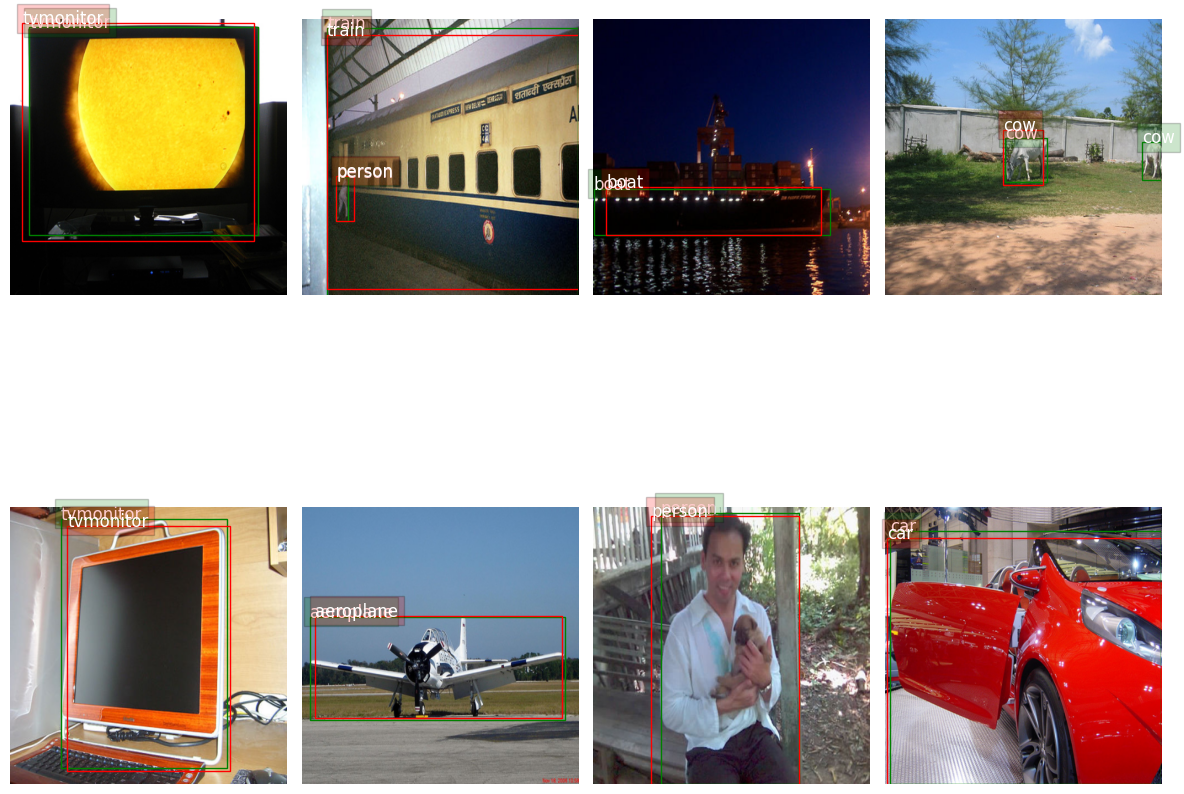

In [20]:
test()